# Import library

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid,save_image
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Prepare data

In [3]:
import os
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Monet_Dataset(Dataset):
    def __init__(self,
                 pathToDataset = "/kaggle/input/gan-getting-started/monet_jpg/",
                 transform = None
                 ) -> None:
        super().__init__()

        self.pathToDataset = pathToDataset

        # Defining transformer
        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.ToTensor()

        self.imageDir = os.listdir(pathToDataset)

    def __len__(self):
        return len(self.imageDir)

    def __getitem__(self, index):
        imagePath = self.pathToDataset + self.imageDir[index]
        image = Image.open(imagePath)
        image = self.transform(image)

        return image

In [4]:
#Hyperparameter
batch_size = 8
image_size = 64
normalization_stats = (0.4819, 0.4324, 0.3845), (0.2604, 0.2520, 0.2539)
data_dir = r'/kaggle/input/gan-getting-started/monet_jpg/'
normal_dataset = Monet_Dataset(data_dir, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*normalization_stats)]))

In [5]:
data_loader = DataLoader(dataset=normal_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=False)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Display some image

In [6]:
def denorm(image):
    return image * normalization_stats[1][0] + normalization_stats[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataloader, nmax=64):
    for images in dataloader:
        show_images(images, nmax)
        break

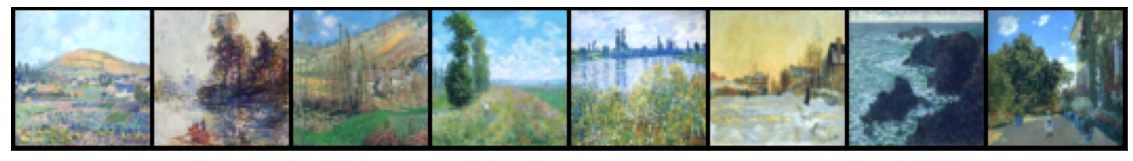

In [8]:
show_batch(data_loader)

# Model

In [9]:
discriminator = nn.Sequential(
    # Input is 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 16 x 16
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 8 x 8
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)
discriminator.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [10]:
seed_size = 16

In [11]:
generator = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 128, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 8 x 8
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 64 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 32 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 64 x 64
)
generator.to(device)

Sequential(
  (0): ConvTranspose2d(16, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

# Training

In [12]:
def train_discriminator(real_pokemon, disc_optimizer):
    # Reset the gradients for the optimizer
    disc_optimizer.zero_grad()
    
    # Train on the real images
    real_predictions = discriminator(real_pokemon)
    # real_targets = torch.zeros(real_pokemon.size(0), 1, device=device) # All of these are real, so the target is 0.
    real_targets = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0 # Add some noisy labels to make the discriminator think harder.
    real_loss = F.binary_cross_entropy(real_predictions, real_targets) # Can do binary loss function because it is a binary classifier
    real_score = torch.mean(real_predictions).item() # How well does the discriminator classify the real pokemon? (Higher score is better for the discriminator)
    
    # Make some latent tensors to seed the generator
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    
    # Get some fake pokemon
    fake_pokemon = generator(latent_batch)
    
    # Train on the generator's current efforts to trick the discriminator
    gen_predictions = discriminator(fake_pokemon)
    # gen_targets = torch.ones(fake_pokemon.size(0), 1, device=device)
    gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9 # Add some noisy labels to make the discriminator think harder.
    gen_loss = F.binary_cross_entropy(gen_predictions, gen_targets)
    gen_score = torch.mean(gen_predictions).item() # How well did the discriminator classify the fake pokemon? (Lower score is better for the discriminator)
    
    # Update the discriminator weights
    total_loss = real_loss + gen_loss
    total_loss.backward()
    disc_optimizer.step()
    return total_loss.item(), real_score, gen_score

In [13]:
def train_generator(gen_optimizer):
    # Clear the generator gradients
    gen_optimizer.zero_grad()
    
    # Generate some fake pokemon
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    fake_pokemon = generator(latent_batch)
    
    # Test against the discriminator
    disc_predictions = discriminator(fake_pokemon)
    targets = torch.zeros(fake_pokemon.size(0), 1, device=device) # We want the discriminator to think these images are real.
    loss = F.binary_cross_entropy(disc_predictions, targets) # How well did the generator do? (How much did the discriminator believe the generator?)
    
    # Update the generator based on how well it fooled the discriminator
    loss.backward()
    gen_optimizer.step()
    
    # Return generator loss
    return loss.item()

# Save result

In [14]:
import os
from torchvision.utils import save_image

RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

def save_results(index, latent_batch, show=True):
    # Generate fake pokemon
    fake_pokemon = generator(latent_batch)
    
    # Make the filename for the output
    fake_file = "result-image-{0:0=4d}.png".format(index)
    
    # Save the image
    save_image(denorm(fake_pokemon), os.path.join(RESULTS_DIR, fake_file), nrow=8)
    print("Result Saved!")
    
    if show:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_pokemon.cpu().detach(), nrow=8).permute(1, 2, 0))

In [15]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

# Static generation seed batch
fixed_latent_batch = torch.randn(64, seed_size, 1, 1, device=device)

def train(epochs, learning_rate, start_idx=1):
    # Empty the GPU cache to save some memory
    torch.cuda.empty_cache()
    
    # Track losses and scores
    disc_losses = []
    disc_scores = []
    gen_losses = []
    gen_scores = []
    
    # Create the optimizers
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    
    # Run the loop
    for epoch in range(epochs):
        # Go through each image
        for real_img in tqdm(data_loader):
            real_img = real_img.to(device)
            # Train the discriminator
            disc_loss, real_score, gen_score = train_discriminator(real_img, disc_optimizer)

            # Train the generator
            gen_loss = train_generator(gen_optimizer)
        
        # Collect results
        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)
        
        # Print the losses and scores
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch+start_idx, epochs, gen_loss, disc_loss, real_score, gen_score))
        
        # Save the images and show the progress
        save_results(epoch + start_idx, fixed_latent_batch, show=False)
    
    # Return stats
    return disc_losses, disc_scores, gen_losses, gen_scores

In [16]:
learning_rate = 1e-4
epochs = 300

In [17]:
history = train(epochs, learning_rate)

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [1/300], gen_loss: 1.9804, disc_loss: 0.8335, real_score: 0.2426, gen_score: 0.6991
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [2/300], gen_loss: 2.5764, disc_loss: 0.4749, real_score: 0.1197, gen_score: 0.8828
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [3/300], gen_loss: 3.6489, disc_loss: 0.4849, real_score: 0.0529, gen_score: 0.8753
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [4/300], gen_loss: 3.2754, disc_loss: 0.3745, real_score: 0.0719, gen_score: 0.9268
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [5/300], gen_loss: 3.7910, disc_loss: 0.4001, real_score: 0.0674, gen_score: 0.9535
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [6/300], gen_loss: 4.2498, disc_loss: 0.4874, real_score: 0.2380, gen_score: 0.9589
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [7/300], gen_loss: 2.3434, disc_loss: 0.9609, real_score: 0.4904, gen_score: 0.8784
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [8/300], gen_loss: 2.2370, disc_loss: 0.4676, real_score: 0.1797, gen_score: 0.9482
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [9/300], gen_loss: 3.3331, disc_loss: 0.4939, real_score: 0.0543, gen_score: 0.8990
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [10/300], gen_loss: 4.5180, disc_loss: 0.3446, real_score: 0.0338, gen_score: 0.9639
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [11/300], gen_loss: 4.7983, disc_loss: 0.3602, real_score: 0.0840, gen_score: 0.8778
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [12/300], gen_loss: 3.0371, disc_loss: 0.3907, real_score: 0.0733, gen_score: 0.9705
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [13/300], gen_loss: 3.1682, disc_loss: 0.4550, real_score: 0.0701, gen_score: 0.9825
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [14/300], gen_loss: 3.3287, disc_loss: 0.3870, real_score: 0.0832, gen_score: 0.9269
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [15/300], gen_loss: 3.3162, disc_loss: 0.5357, real_score: 0.0672, gen_score: 0.9816
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [16/300], gen_loss: 3.1429, disc_loss: 0.3487, real_score: 0.0541, gen_score: 0.9587
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [17/300], gen_loss: 3.5095, disc_loss: 0.4040, real_score: 0.0507, gen_score: 0.9643
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [18/300], gen_loss: 3.5502, disc_loss: 0.4137, real_score: 0.0326, gen_score: 0.9450
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [19/300], gen_loss: 3.5739, disc_loss: 0.4025, real_score: 0.0533, gen_score: 0.9344
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [20/300], gen_loss: 3.2571, disc_loss: 0.3823, real_score: 0.0289, gen_score: 0.9275
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [21/300], gen_loss: 6.3617, disc_loss: 0.3823, real_score: 0.0984, gen_score: 0.9940
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [22/300], gen_loss: 2.7835, disc_loss: 0.4278, real_score: 0.0966, gen_score: 0.8856
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [23/300], gen_loss: 1.8758, disc_loss: 0.6809, real_score: 0.2413, gen_score: 0.7886
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [24/300], gen_loss: 2.7261, disc_loss: 0.4056, real_score: 0.0238, gen_score: 0.8823
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [25/300], gen_loss: 2.5677, disc_loss: 0.5637, real_score: 0.2519, gen_score: 0.9049
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [26/300], gen_loss: 1.4299, disc_loss: 1.0560, real_score: 0.5241, gen_score: 0.9389
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [27/300], gen_loss: 2.8950, disc_loss: 0.5430, real_score: 0.2581, gen_score: 0.9468
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [28/300], gen_loss: 3.4642, disc_loss: 0.5532, real_score: 0.1276, gen_score: 0.9203
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [29/300], gen_loss: 2.6296, disc_loss: 0.5331, real_score: 0.1618, gen_score: 0.7770
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [30/300], gen_loss: 2.6310, disc_loss: 0.8157, real_score: 0.2796, gen_score: 0.7990
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [31/300], gen_loss: 0.8848, disc_loss: 1.2168, real_score: 0.6228, gen_score: 0.8589
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [32/300], gen_loss: 1.3766, disc_loss: 1.1865, real_score: 0.4152, gen_score: 0.7612
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [33/300], gen_loss: 2.0875, disc_loss: 0.4745, real_score: 0.0989, gen_score: 0.8571
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [34/300], gen_loss: 2.0587, disc_loss: 1.3731, real_score: 0.5937, gen_score: 0.8825
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [35/300], gen_loss: 1.1486, disc_loss: 1.0191, real_score: 0.4707, gen_score: 0.7745
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [36/300], gen_loss: 2.2029, disc_loss: 0.6861, real_score: 0.1693, gen_score: 0.7012
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [37/300], gen_loss: 1.1882, disc_loss: 1.2493, real_score: 0.5856, gen_score: 0.8720
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [38/300], gen_loss: 1.0105, disc_loss: 1.1368, real_score: 0.2323, gen_score: 0.4997
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [39/300], gen_loss: 1.8305, disc_loss: 1.0804, real_score: 0.5374, gen_score: 0.8883
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [40/300], gen_loss: 1.5821, disc_loss: 1.4286, real_score: 0.6779, gen_score: 0.8855
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [41/300], gen_loss: 0.9891, disc_loss: 0.7576, real_score: 0.2987, gen_score: 0.7573
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [42/300], gen_loss: 1.3813, disc_loss: 1.1681, real_score: 0.5842, gen_score: 0.8485
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [43/300], gen_loss: 3.1051, disc_loss: 0.6383, real_score: 0.2734, gen_score: 0.8554
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [44/300], gen_loss: 2.2981, disc_loss: 0.6036, real_score: 0.1769, gen_score: 0.8105
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [45/300], gen_loss: 1.6262, disc_loss: 0.9396, real_score: 0.4086, gen_score: 0.7820
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [46/300], gen_loss: 1.3289, disc_loss: 0.5997, real_score: 0.1331, gen_score: 0.7158
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [47/300], gen_loss: 1.8736, disc_loss: 0.9733, real_score: 0.0920, gen_score: 0.5250
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [48/300], gen_loss: 0.6727, disc_loss: 1.0330, real_score: 0.5122, gen_score: 0.8427
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [49/300], gen_loss: 2.0030, disc_loss: 0.9082, real_score: 0.2475, gen_score: 0.6369
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [50/300], gen_loss: 1.7861, disc_loss: 1.6160, real_score: 0.1804, gen_score: 0.2842
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [51/300], gen_loss: 1.9982, disc_loss: 0.7662, real_score: 0.4195, gen_score: 0.9087
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [52/300], gen_loss: 1.7665, disc_loss: 0.5835, real_score: 0.2151, gen_score: 0.8618
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [53/300], gen_loss: 1.5682, disc_loss: 1.2636, real_score: 0.5330, gen_score: 0.7149
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [54/300], gen_loss: 2.1283, disc_loss: 1.1409, real_score: 0.1737, gen_score: 0.4357
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [55/300], gen_loss: 1.2036, disc_loss: 0.7972, real_score: 0.4137, gen_score: 0.8828
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [56/300], gen_loss: 1.2321, disc_loss: 0.6272, real_score: 0.0983, gen_score: 0.7198
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [57/300], gen_loss: 0.9463, disc_loss: 1.2476, real_score: 0.5209, gen_score: 0.7096
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [58/300], gen_loss: 2.8613, disc_loss: 0.9696, real_score: 0.1784, gen_score: 0.5311
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [59/300], gen_loss: 2.7616, disc_loss: 1.0036, real_score: 0.3345, gen_score: 0.6306
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [60/300], gen_loss: 2.0571, disc_loss: 0.6439, real_score: 0.1831, gen_score: 0.7410
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [61/300], gen_loss: 1.9549, disc_loss: 2.0147, real_score: 0.7901, gen_score: 0.8219
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [62/300], gen_loss: 2.6124, disc_loss: 0.5966, real_score: 0.1098, gen_score: 0.7398
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [63/300], gen_loss: 1.7215, disc_loss: 0.7295, real_score: 0.2460, gen_score: 0.7495
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [64/300], gen_loss: 2.2530, disc_loss: 0.5077, real_score: 0.1868, gen_score: 0.9163
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [65/300], gen_loss: 1.9616, disc_loss: 0.7530, real_score: 0.2367, gen_score: 0.7605
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [66/300], gen_loss: 2.8477, disc_loss: 0.4544, real_score: 0.0696, gen_score: 0.8335
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [67/300], gen_loss: 1.1350, disc_loss: 0.8198, real_score: 0.2725, gen_score: 0.6724
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [68/300], gen_loss: 1.5717, disc_loss: 1.0867, real_score: 0.4826, gen_score: 0.7266
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [69/300], gen_loss: 2.8614, disc_loss: 1.6280, real_score: 0.0685, gen_score: 0.2648
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [70/300], gen_loss: 1.7893, disc_loss: 0.8557, real_score: 0.3567, gen_score: 0.7564
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [71/300], gen_loss: 2.2779, disc_loss: 0.6176, real_score: 0.1299, gen_score: 0.7171
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [72/300], gen_loss: 2.5015, disc_loss: 0.5550, real_score: 0.0634, gen_score: 0.7683
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [73/300], gen_loss: 2.2326, disc_loss: 1.0277, real_score: 0.3116, gen_score: 0.6151
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [74/300], gen_loss: 1.2290, disc_loss: 1.1802, real_score: 0.5311, gen_score: 0.9153
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [75/300], gen_loss: 1.3768, disc_loss: 1.1875, real_score: 0.5709, gen_score: 0.8196
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [76/300], gen_loss: 1.3956, disc_loss: 1.0327, real_score: 0.4812, gen_score: 0.7242
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [77/300], gen_loss: 2.2954, disc_loss: 0.7546, real_score: 0.3419, gen_score: 0.8648
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [78/300], gen_loss: 2.6692, disc_loss: 0.5341, real_score: 0.1292, gen_score: 0.7935
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [79/300], gen_loss: 2.6493, disc_loss: 0.5578, real_score: 0.0888, gen_score: 0.7431
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [80/300], gen_loss: 2.1147, disc_loss: 0.7223, real_score: 0.3533, gen_score: 0.8587
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [81/300], gen_loss: 2.7874, disc_loss: 0.6022, real_score: 0.1894, gen_score: 0.8846
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [82/300], gen_loss: 1.3658, disc_loss: 0.8280, real_score: 0.3680, gen_score: 0.8668
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [83/300], gen_loss: 3.7142, disc_loss: 0.5917, real_score: 0.1263, gen_score: 0.7848
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [84/300], gen_loss: 3.3806, disc_loss: 0.4360, real_score: 0.1374, gen_score: 0.9367
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [85/300], gen_loss: 2.3741, disc_loss: 0.8337, real_score: 0.0118, gen_score: 0.6857
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [86/300], gen_loss: 2.6440, disc_loss: 0.7549, real_score: 0.0881, gen_score: 0.6518
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [87/300], gen_loss: 1.3959, disc_loss: 1.2996, real_score: 0.4612, gen_score: 0.5647
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [88/300], gen_loss: 2.7127, disc_loss: 0.4934, real_score: 0.1199, gen_score: 0.8619
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [89/300], gen_loss: 2.6658, disc_loss: 0.4986, real_score: 0.0195, gen_score: 0.7945
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [90/300], gen_loss: 3.9338, disc_loss: 0.5205, real_score: 0.1250, gen_score: 0.8904
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [91/300], gen_loss: 2.7915, disc_loss: 0.7491, real_score: 0.1222, gen_score: 0.6437
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [92/300], gen_loss: 2.4348, disc_loss: 0.6571, real_score: 0.2603, gen_score: 0.8437
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [93/300], gen_loss: 1.9428, disc_loss: 1.0084, real_score: 0.5388, gen_score: 0.8778
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [94/300], gen_loss: 3.1344, disc_loss: 0.5141, real_score: 0.0960, gen_score: 0.8893
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [95/300], gen_loss: 1.7396, disc_loss: 0.6837, real_score: 0.2873, gen_score: 0.8287
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [96/300], gen_loss: 3.1123, disc_loss: 0.6917, real_score: 0.2173, gen_score: 0.7740
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [97/300], gen_loss: 1.7672, disc_loss: 0.6398, real_score: 0.2275, gen_score: 0.8870
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [98/300], gen_loss: 2.0692, disc_loss: 0.7871, real_score: 0.2329, gen_score: 0.7116
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [99/300], gen_loss: 2.9152, disc_loss: 0.6699, real_score: 0.3651, gen_score: 0.9515
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [100/300], gen_loss: 2.2430, disc_loss: 0.8392, real_score: 0.3170, gen_score: 0.9398
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [101/300], gen_loss: 2.1949, disc_loss: 0.7226, real_score: 0.0421, gen_score: 0.5942
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [102/300], gen_loss: 1.9958, disc_loss: 0.7149, real_score: 0.3326, gen_score: 0.8716
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [103/300], gen_loss: 2.4620, disc_loss: 0.6642, real_score: 0.1302, gen_score: 0.7597
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [104/300], gen_loss: 2.2086, disc_loss: 0.6251, real_score: 0.2023, gen_score: 0.8420
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [105/300], gen_loss: 2.6498, disc_loss: 0.4924, real_score: 0.1755, gen_score: 0.9330
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [106/300], gen_loss: 2.4482, disc_loss: 0.5473, real_score: 0.0981, gen_score: 0.8311
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [107/300], gen_loss: 1.6077, disc_loss: 0.5046, real_score: 0.1188, gen_score: 0.8890
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [108/300], gen_loss: 1.7403, disc_loss: 0.6294, real_score: 0.2041, gen_score: 0.7846
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [109/300], gen_loss: 3.0990, disc_loss: 0.6124, real_score: 0.2705, gen_score: 0.9419
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [110/300], gen_loss: 2.5616, disc_loss: 0.5819, real_score: 0.1898, gen_score: 0.8337
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [111/300], gen_loss: 1.0866, disc_loss: 0.9632, real_score: 0.3568, gen_score: 0.7088
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [112/300], gen_loss: 3.2666, disc_loss: 0.6122, real_score: 0.2576, gen_score: 0.9054
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [113/300], gen_loss: 1.2464, disc_loss: 0.9193, real_score: 0.4521, gen_score: 0.9384
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [114/300], gen_loss: 1.4448, disc_loss: 0.4966, real_score: 0.0624, gen_score: 0.8493
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [115/300], gen_loss: 1.4941, disc_loss: 0.5285, real_score: 0.1537, gen_score: 0.8365
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [116/300], gen_loss: 4.4685, disc_loss: 0.4916, real_score: 0.0938, gen_score: 0.8569
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [117/300], gen_loss: 3.9546, disc_loss: 0.3928, real_score: 0.0169, gen_score: 0.8684
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [118/300], gen_loss: 2.4564, disc_loss: 0.6364, real_score: 0.2387, gen_score: 0.8745
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [119/300], gen_loss: 2.6270, disc_loss: 0.5737, real_score: 0.2297, gen_score: 0.8942
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [120/300], gen_loss: 2.3112, disc_loss: 0.6088, real_score: 0.2995, gen_score: 0.9082
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [121/300], gen_loss: 2.9627, disc_loss: 0.6282, real_score: 0.2347, gen_score: 0.8064
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [122/300], gen_loss: 1.4708, disc_loss: 0.5591, real_score: 0.2086, gen_score: 0.8855
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [123/300], gen_loss: 3.4855, disc_loss: 0.4983, real_score: 0.0794, gen_score: 0.8566
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [124/300], gen_loss: 0.5546, disc_loss: 0.8873, real_score: 0.4682, gen_score: 0.9522
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [125/300], gen_loss: 3.0649, disc_loss: 0.4913, real_score: 0.1161, gen_score: 0.8715
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [126/300], gen_loss: 1.8357, disc_loss: 0.6505, real_score: 0.1061, gen_score: 0.7437
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [127/300], gen_loss: 3.1103, disc_loss: 0.6337, real_score: 0.1177, gen_score: 0.8293
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [128/300], gen_loss: 2.9595, disc_loss: 0.5613, real_score: 0.0844, gen_score: 0.7695
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [129/300], gen_loss: 4.5550, disc_loss: 0.5363, real_score: 0.1981, gen_score: 0.9550
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [130/300], gen_loss: 3.1336, disc_loss: 0.4553, real_score: 0.0134, gen_score: 0.8254
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [131/300], gen_loss: 3.2948, disc_loss: 0.5660, real_score: 0.0990, gen_score: 0.8224
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [132/300], gen_loss: 3.0283, disc_loss: 0.5375, real_score: 0.1829, gen_score: 0.9200
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [133/300], gen_loss: 3.3296, disc_loss: 0.4981, real_score: 0.1130, gen_score: 0.8461
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [134/300], gen_loss: 2.6437, disc_loss: 0.4257, real_score: 0.0350, gen_score: 0.8782
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [135/300], gen_loss: 2.7846, disc_loss: 0.4311, real_score: 0.1060, gen_score: 0.8843
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [136/300], gen_loss: 1.7835, disc_loss: 0.6153, real_score: 0.2726, gen_score: 0.9042
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [137/300], gen_loss: 0.9040, disc_loss: 1.3665, real_score: 0.6395, gen_score: 0.7763
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [138/300], gen_loss: 2.2404, disc_loss: 0.6195, real_score: 0.2309, gen_score: 0.8286
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [139/300], gen_loss: 1.4510, disc_loss: 0.6066, real_score: 0.1389, gen_score: 0.7378
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [140/300], gen_loss: 3.3955, disc_loss: 0.4037, real_score: 0.0674, gen_score: 0.9381
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [141/300], gen_loss: 2.9932, disc_loss: 0.6896, real_score: 0.2853, gen_score: 0.9435
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [142/300], gen_loss: 1.7616, disc_loss: 0.5613, real_score: 0.2291, gen_score: 0.9388
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [143/300], gen_loss: 2.5573, disc_loss: 0.6036, real_score: 0.2182, gen_score: 0.9455
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [144/300], gen_loss: 2.6233, disc_loss: 0.5478, real_score: 0.1689, gen_score: 0.8590
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [145/300], gen_loss: 2.7896, disc_loss: 0.9498, real_score: 0.4655, gen_score: 0.9511
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [146/300], gen_loss: 2.7059, disc_loss: 0.5343, real_score: 0.2005, gen_score: 0.9155
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [147/300], gen_loss: 2.8585, disc_loss: 0.5081, real_score: 0.0743, gen_score: 0.8968
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [148/300], gen_loss: 2.9085, disc_loss: 0.4120, real_score: 0.1267, gen_score: 0.9336
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [149/300], gen_loss: 3.8686, disc_loss: 0.4010, real_score: 0.1157, gen_score: 0.9382
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [150/300], gen_loss: 2.5797, disc_loss: 0.4727, real_score: 0.0677, gen_score: 0.8911
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [151/300], gen_loss: 2.4472, disc_loss: 0.5348, real_score: 0.2160, gen_score: 0.9137
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [152/300], gen_loss: 2.4843, disc_loss: 0.5105, real_score: 0.1267, gen_score: 0.8796
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [153/300], gen_loss: 2.8236, disc_loss: 0.5990, real_score: 0.1312, gen_score: 0.8859
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [154/300], gen_loss: 3.5922, disc_loss: 0.6233, real_score: 0.0166, gen_score: 0.7039
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [155/300], gen_loss: 3.5314, disc_loss: 0.4874, real_score: 0.0864, gen_score: 0.9201
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [156/300], gen_loss: 2.2901, disc_loss: 0.4780, real_score: 0.1547, gen_score: 0.9464
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [157/300], gen_loss: 3.6539, disc_loss: 0.6758, real_score: 0.1187, gen_score: 0.6746
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [158/300], gen_loss: 3.4405, disc_loss: 0.4717, real_score: 0.1164, gen_score: 0.9357
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [159/300], gen_loss: 2.0097, disc_loss: 0.5304, real_score: 0.2049, gen_score: 0.9269
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [160/300], gen_loss: 3.1096, disc_loss: 0.3925, real_score: 0.0591, gen_score: 0.9159
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [161/300], gen_loss: 2.5572, disc_loss: 0.4087, real_score: 0.1174, gen_score: 0.8955
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [162/300], gen_loss: 4.6814, disc_loss: 0.4269, real_score: 0.0470, gen_score: 0.9438
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [163/300], gen_loss: 1.9142, disc_loss: 0.7415, real_score: 0.3483, gen_score: 0.9199
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [164/300], gen_loss: 0.7599, disc_loss: 0.8319, real_score: 0.4307, gen_score: 0.8926
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [165/300], gen_loss: 2.3683, disc_loss: 0.5066, real_score: 0.0468, gen_score: 0.8983
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [166/300], gen_loss: 3.4589, disc_loss: 0.3839, real_score: 0.1198, gen_score: 0.9606
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [167/300], gen_loss: 3.1518, disc_loss: 0.5607, real_score: 0.2134, gen_score: 0.9231
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [168/300], gen_loss: 2.5301, disc_loss: 0.5092, real_score: 0.2423, gen_score: 0.9274
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [169/300], gen_loss: 2.2371, disc_loss: 0.5400, real_score: 0.2784, gen_score: 0.9332
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [170/300], gen_loss: 3.2599, disc_loss: 0.5621, real_score: 0.1469, gen_score: 0.8725
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [171/300], gen_loss: 2.1651, disc_loss: 0.6156, real_score: 0.1691, gen_score: 0.9288
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [172/300], gen_loss: 3.6270, disc_loss: 0.4950, real_score: 0.1711, gen_score: 0.8968
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [173/300], gen_loss: 4.3598, disc_loss: 0.5235, real_score: 0.0476, gen_score: 0.7824
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [174/300], gen_loss: 3.1960, disc_loss: 0.7401, real_score: 0.0178, gen_score: 0.8008
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [175/300], gen_loss: 3.2387, disc_loss: 0.5018, real_score: 0.0127, gen_score: 0.8923
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [176/300], gen_loss: 2.7706, disc_loss: 0.4362, real_score: 0.1074, gen_score: 0.9411
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [177/300], gen_loss: 3.5274, disc_loss: 0.4382, real_score: 0.0392, gen_score: 0.8907
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [178/300], gen_loss: 2.9071, disc_loss: 0.5437, real_score: 0.0930, gen_score: 0.8578
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [179/300], gen_loss: 2.6981, disc_loss: 0.9195, real_score: 0.3491, gen_score: 0.9590
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [180/300], gen_loss: 2.8827, disc_loss: 0.3900, real_score: 0.0923, gen_score: 0.9270
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [181/300], gen_loss: 2.9950, disc_loss: 0.4135, real_score: 0.0545, gen_score: 0.8839
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [182/300], gen_loss: 1.4627, disc_loss: 0.6789, real_score: 0.1895, gen_score: 0.8385
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [183/300], gen_loss: 3.1808, disc_loss: 0.4823, real_score: 0.0770, gen_score: 0.8017
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [184/300], gen_loss: 2.9938, disc_loss: 0.5747, real_score: 0.3229, gen_score: 0.9803
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [185/300], gen_loss: 2.2747, disc_loss: 0.4010, real_score: 0.0778, gen_score: 0.9304
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [186/300], gen_loss: 3.5991, disc_loss: 0.3692, real_score: 0.0711, gen_score: 0.8943
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [187/300], gen_loss: 3.0113, disc_loss: 0.4922, real_score: 0.1215, gen_score: 0.8829
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [188/300], gen_loss: 2.9830, disc_loss: 0.5157, real_score: 0.1188, gen_score: 0.8656
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [189/300], gen_loss: 3.1864, disc_loss: 0.4708, real_score: 0.0535, gen_score: 0.9061
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [190/300], gen_loss: 2.2739, disc_loss: 0.3651, real_score: 0.1427, gen_score: 0.9608
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [191/300], gen_loss: 2.7132, disc_loss: 0.4362, real_score: 0.0487, gen_score: 0.8993
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [192/300], gen_loss: 1.8605, disc_loss: 0.6955, real_score: 0.3348, gen_score: 0.9546
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [193/300], gen_loss: 3.3759, disc_loss: 0.4240, real_score: 0.0673, gen_score: 0.8569
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [194/300], gen_loss: 2.5132, disc_loss: 0.4623, real_score: 0.0332, gen_score: 0.8066
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [195/300], gen_loss: 2.8617, disc_loss: 0.4544, real_score: 0.1384, gen_score: 0.9301
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [196/300], gen_loss: 3.6393, disc_loss: 0.4309, real_score: 0.0493, gen_score: 0.9497
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [197/300], gen_loss: 1.7639, disc_loss: 0.4764, real_score: 0.1765, gen_score: 0.9225
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [198/300], gen_loss: 2.7181, disc_loss: 0.5236, real_score: 0.2321, gen_score: 0.9785
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [199/300], gen_loss: 2.9026, disc_loss: 0.5072, real_score: 0.1494, gen_score: 0.8656
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [200/300], gen_loss: 3.0546, disc_loss: 1.0605, real_score: 0.5122, gen_score: 0.9780
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [201/300], gen_loss: 2.5114, disc_loss: 0.4740, real_score: 0.0570, gen_score: 0.9296
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [202/300], gen_loss: 1.9774, disc_loss: 0.5781, real_score: 0.2591, gen_score: 0.9871
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [203/300], gen_loss: 2.7957, disc_loss: 0.6341, real_score: 0.3141, gen_score: 0.9465
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [204/300], gen_loss: 2.6655, disc_loss: 0.4803, real_score: 0.1480, gen_score: 0.9499
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [205/300], gen_loss: 1.6099, disc_loss: 0.6657, real_score: 0.3226, gen_score: 0.9242
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [206/300], gen_loss: 2.8374, disc_loss: 0.4754, real_score: 0.0840, gen_score: 0.8827
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [207/300], gen_loss: 3.2264, disc_loss: 0.4712, real_score: 0.1629, gen_score: 0.9664
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [208/300], gen_loss: 2.7785, disc_loss: 0.4337, real_score: 0.1393, gen_score: 0.9365
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [209/300], gen_loss: 2.5856, disc_loss: 0.5897, real_score: 0.2485, gen_score: 0.9781
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [210/300], gen_loss: 2.7101, disc_loss: 0.5902, real_score: 0.0948, gen_score: 0.8750
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [211/300], gen_loss: 2.6959, disc_loss: 0.4819, real_score: 0.0660, gen_score: 0.9605
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [212/300], gen_loss: 3.2082, disc_loss: 0.4713, real_score: 0.0868, gen_score: 0.8902
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [213/300], gen_loss: 4.1256, disc_loss: 0.5165, real_score: 0.0222, gen_score: 0.7814
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [214/300], gen_loss: 2.4844, disc_loss: 0.3939, real_score: 0.0854, gen_score: 0.9494
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [215/300], gen_loss: 2.5134, disc_loss: 0.4916, real_score: 0.1101, gen_score: 0.8717
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [216/300], gen_loss: 2.8215, disc_loss: 0.4280, real_score: 0.1623, gen_score: 0.8913
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [217/300], gen_loss: 3.6928, disc_loss: 0.4977, real_score: 0.0606, gen_score: 0.7697
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [218/300], gen_loss: 2.4957, disc_loss: 0.5046, real_score: 0.1116, gen_score: 0.9400
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [219/300], gen_loss: 2.8596, disc_loss: 0.4030, real_score: 0.1495, gen_score: 0.9228
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [220/300], gen_loss: 2.4850, disc_loss: 0.4790, real_score: 0.1305, gen_score: 0.9096
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [221/300], gen_loss: 3.0603, disc_loss: 0.6182, real_score: 0.1280, gen_score: 0.8003
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [222/300], gen_loss: 2.1468, disc_loss: 0.3712, real_score: 0.1095, gen_score: 0.9539
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [223/300], gen_loss: 2.4948, disc_loss: 0.4978, real_score: 0.1451, gen_score: 0.8938
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [224/300], gen_loss: 3.1276, disc_loss: 0.5183, real_score: 0.0350, gen_score: 0.8174
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [225/300], gen_loss: 2.5844, disc_loss: 0.4961, real_score: 0.0267, gen_score: 0.8948
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [226/300], gen_loss: 3.0930, disc_loss: 0.5349, real_score: 0.0429, gen_score: 0.8806
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [227/300], gen_loss: 3.0248, disc_loss: 0.4335, real_score: 0.0652, gen_score: 0.9565
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [228/300], gen_loss: 3.7017, disc_loss: 0.3676, real_score: 0.0644, gen_score: 0.9528
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [229/300], gen_loss: 2.1626, disc_loss: 0.5724, real_score: 0.1691, gen_score: 0.9192
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [230/300], gen_loss: 3.0030, disc_loss: 0.3686, real_score: 0.0991, gen_score: 0.9676
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [231/300], gen_loss: 3.0438, disc_loss: 0.5042, real_score: 0.1494, gen_score: 0.9176
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [232/300], gen_loss: 2.2059, disc_loss: 0.3850, real_score: 0.0585, gen_score: 0.9146
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [233/300], gen_loss: 2.9636, disc_loss: 0.7014, real_score: 0.0233, gen_score: 0.6897
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [234/300], gen_loss: 2.5245, disc_loss: 0.5280, real_score: 0.1119, gen_score: 0.9027
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [235/300], gen_loss: 3.1940, disc_loss: 0.5456, real_score: 0.2105, gen_score: 0.9486
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [236/300], gen_loss: 2.7582, disc_loss: 0.3869, real_score: 0.1027, gen_score: 0.9657
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [237/300], gen_loss: 2.9121, disc_loss: 0.4672, real_score: 0.0556, gen_score: 0.9106
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [238/300], gen_loss: 3.6515, disc_loss: 0.5335, real_score: 0.0754, gen_score: 0.8809
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [239/300], gen_loss: 2.8691, disc_loss: 0.5321, real_score: 0.1518, gen_score: 0.9476
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [240/300], gen_loss: 3.3450, disc_loss: 0.4946, real_score: 0.0447, gen_score: 0.9064
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [241/300], gen_loss: 2.8179, disc_loss: 0.5420, real_score: 0.0621, gen_score: 0.9396
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [242/300], gen_loss: 4.0345, disc_loss: 0.4654, real_score: 0.0251, gen_score: 0.9167
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [243/300], gen_loss: 2.1858, disc_loss: 0.4181, real_score: 0.0325, gen_score: 0.9425
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [244/300], gen_loss: 2.6612, disc_loss: 0.3564, real_score: 0.0429, gen_score: 0.9209
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [245/300], gen_loss: 2.3780, disc_loss: 0.4975, real_score: 0.1788, gen_score: 0.9394
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [246/300], gen_loss: 2.1648, disc_loss: 0.4257, real_score: 0.0771, gen_score: 0.9563
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [247/300], gen_loss: 2.9237, disc_loss: 0.5024, real_score: 0.0973, gen_score: 0.9517
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [248/300], gen_loss: 3.1411, disc_loss: 0.4719, real_score: 0.0386, gen_score: 0.9429
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [249/300], gen_loss: 2.8495, disc_loss: 0.4088, real_score: 0.0310, gen_score: 0.9506
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [250/300], gen_loss: 2.9929, disc_loss: 0.4161, real_score: 0.0512, gen_score: 0.8982
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [251/300], gen_loss: 1.6639, disc_loss: 0.5860, real_score: 0.2574, gen_score: 0.9511
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [252/300], gen_loss: 3.4262, disc_loss: 0.4923, real_score: 0.0377, gen_score: 0.9196
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [253/300], gen_loss: 4.7768, disc_loss: 0.5866, real_score: 0.0400, gen_score: 0.7907
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [254/300], gen_loss: 2.8475, disc_loss: 0.4896, real_score: 0.1761, gen_score: 0.8787
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [255/300], gen_loss: 3.1699, disc_loss: 0.4674, real_score: 0.1190, gen_score: 0.9100
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [256/300], gen_loss: 3.1837, disc_loss: 0.3216, real_score: 0.0798, gen_score: 0.9366
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [257/300], gen_loss: 3.8332, disc_loss: 0.4791, real_score: 0.1325, gen_score: 0.9738
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [258/300], gen_loss: 2.8093, disc_loss: 0.4769, real_score: 0.0503, gen_score: 0.9584
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [259/300], gen_loss: 3.4189, disc_loss: 0.3908, real_score: 0.0622, gen_score: 0.9263
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [260/300], gen_loss: 3.3633, disc_loss: 0.4831, real_score: 0.1091, gen_score: 0.9341
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [261/300], gen_loss: 3.4040, disc_loss: 0.4265, real_score: 0.0527, gen_score: 0.9751
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [262/300], gen_loss: 3.2493, disc_loss: 0.4548, real_score: 0.1528, gen_score: 0.9214
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [263/300], gen_loss: 2.8592, disc_loss: 0.3997, real_score: 0.1116, gen_score: 0.9645
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [264/300], gen_loss: 2.7417, disc_loss: 0.4657, real_score: 0.1568, gen_score: 0.9144
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [265/300], gen_loss: 3.0311, disc_loss: 0.4765, real_score: 0.1093, gen_score: 0.9561
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [266/300], gen_loss: 2.4972, disc_loss: 0.4819, real_score: 0.1286, gen_score: 0.9198
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [267/300], gen_loss: 2.8103, disc_loss: 0.4530, real_score: 0.0986, gen_score: 0.9484
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [268/300], gen_loss: 3.7664, disc_loss: 0.4555, real_score: 0.1313, gen_score: 0.9306
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [269/300], gen_loss: 2.9951, disc_loss: 0.4135, real_score: 0.0828, gen_score: 0.9731
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [270/300], gen_loss: 2.4723, disc_loss: 0.4189, real_score: 0.1457, gen_score: 0.9341
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [271/300], gen_loss: 3.6722, disc_loss: 0.5028, real_score: 0.0358, gen_score: 0.8022
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [272/300], gen_loss: 2.3760, disc_loss: 0.5191, real_score: 0.0812, gen_score: 0.9524
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [273/300], gen_loss: 2.9720, disc_loss: 0.5459, real_score: 0.0681, gen_score: 0.8849
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [274/300], gen_loss: 2.0742, disc_loss: 0.4065, real_score: 0.1667, gen_score: 0.9634
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [275/300], gen_loss: 2.6472, disc_loss: 0.5173, real_score: 0.1828, gen_score: 0.9617
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [276/300], gen_loss: 2.4616, disc_loss: 0.5337, real_score: 0.1139, gen_score: 0.9623
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [277/300], gen_loss: 2.6412, disc_loss: 0.4629, real_score: 0.0959, gen_score: 0.9433
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [278/300], gen_loss: 2.7441, disc_loss: 0.5464, real_score: 0.2026, gen_score: 0.9520
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [279/300], gen_loss: 3.4691, disc_loss: 0.3924, real_score: 0.0302, gen_score: 0.9271
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [280/300], gen_loss: 2.7866, disc_loss: 0.5260, real_score: 0.0923, gen_score: 0.8735
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [281/300], gen_loss: 3.6309, disc_loss: 0.4129, real_score: 0.0486, gen_score: 0.9038
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [282/300], gen_loss: 2.9244, disc_loss: 0.4333, real_score: 0.0389, gen_score: 0.9275
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [283/300], gen_loss: 2.8804, disc_loss: 0.4636, real_score: 0.0979, gen_score: 0.9122
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [284/300], gen_loss: 2.9046, disc_loss: 0.3762, real_score: 0.0521, gen_score: 0.9536
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [285/300], gen_loss: 3.2891, disc_loss: 0.5391, real_score: 0.0460, gen_score: 0.9730
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [286/300], gen_loss: 2.9458, disc_loss: 0.4487, real_score: 0.0647, gen_score: 0.9357
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [287/300], gen_loss: 2.3450, disc_loss: 0.3987, real_score: 0.0514, gen_score: 0.9362
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [288/300], gen_loss: 3.4847, disc_loss: 0.4007, real_score: 0.1124, gen_score: 0.9592
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [289/300], gen_loss: 1.9009, disc_loss: 0.4258, real_score: 0.1647, gen_score: 0.9412
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [290/300], gen_loss: 3.4016, disc_loss: 0.3987, real_score: 0.0709, gen_score: 0.8938
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [291/300], gen_loss: 2.9871, disc_loss: 0.4120, real_score: 0.1085, gen_score: 0.9509
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [292/300], gen_loss: 2.8671, disc_loss: 0.3229, real_score: 0.0733, gen_score: 0.9683
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [293/300], gen_loss: 2.5082, disc_loss: 0.4624, real_score: 0.0205, gen_score: 0.8563
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [294/300], gen_loss: 1.8708, disc_loss: 0.4613, real_score: 0.0632, gen_score: 0.9604
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [295/300], gen_loss: 3.4327, disc_loss: 0.4650, real_score: 0.1197, gen_score: 0.9642
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [296/300], gen_loss: 2.7856, disc_loss: 0.5119, real_score: 0.1674, gen_score: 0.9640
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [297/300], gen_loss: 3.5129, disc_loss: 0.4186, real_score: 0.0699, gen_score: 0.9496
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [298/300], gen_loss: 1.6779, disc_loss: 0.4837, real_score: 0.0784, gen_score: 0.9577
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [299/300], gen_loss: 2.6945, disc_loss: 0.3444, real_score: 0.0883, gen_score: 0.9508
Result Saved!


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [300/300], gen_loss: 2.5190, disc_loss: 0.4678, real_score: 0.1039, gen_score: 0.9695
Result Saved!


# Show some fake images

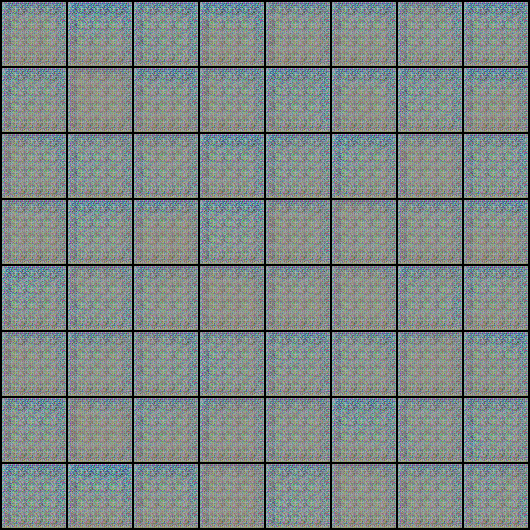

In [26]:
from IPython.display import Image
Image('./results/result-image-0010.png')

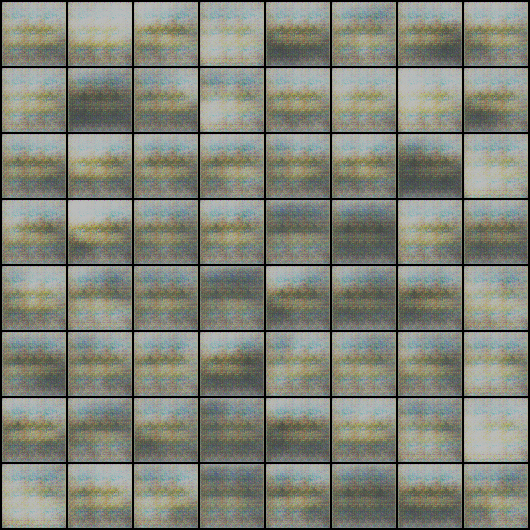

In [27]:
Image('./results/result-image-0025.png')

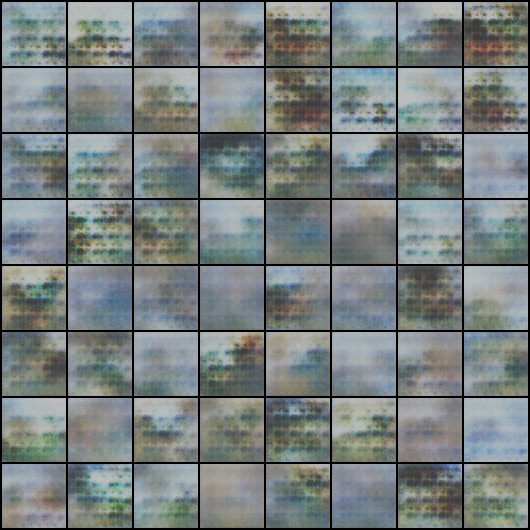

In [28]:
Image('./results/result-image-0050.png')

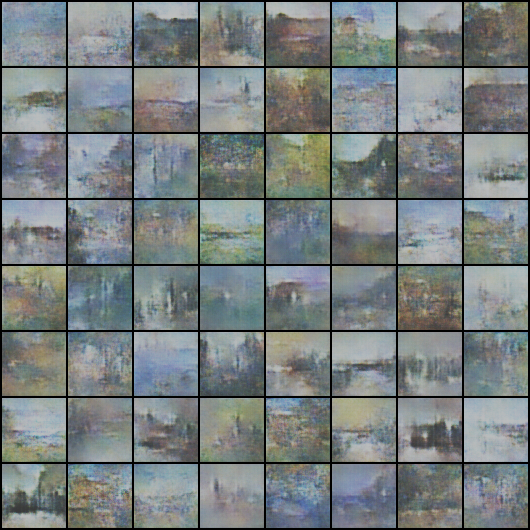

In [29]:
Image('./results/result-image-0150.png')

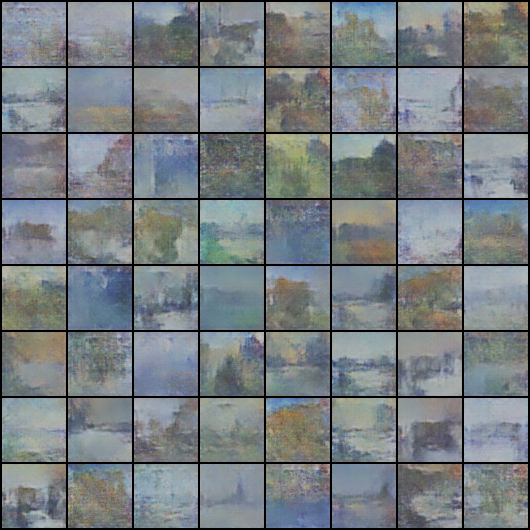

In [30]:
Image('./results/result-image-0300.png')

In [23]:
disc_losses, disc_scores, gen_losses, gen_scores = history

# Plotting

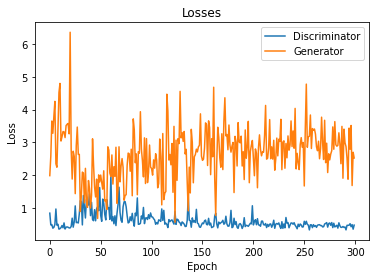

In [31]:
# Plot generator and discriminator losses
plt.plot(disc_losses, '-')
plt.plot(gen_losses, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

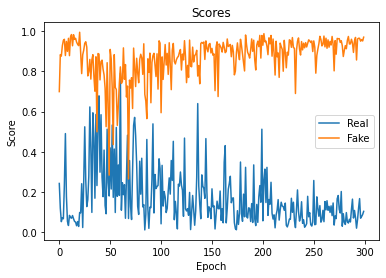

In [32]:
# Plots scores vs. epochs
plt.plot(disc_scores, '-')
plt.plot(gen_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');